# Assignment

So far we have been studying time series that we generated using a pre-defined stochastic process, but now let's apply the models we have been working with on some real-world data. We will work with a data set which shows the consumption of chocolate, beer and electricity in Australia from 1958 to 1991.

In [1]:
from math import sin, pi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as nr

import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error

import statsmodels.graphics.tsaplots as splt
import statsmodels.api as statsmodels
import statsmodels.formula.api as sm
import statsmodels.tsa.seasonal as sts
import statsmodels.tsa.arima_process as arima_process
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 5]

import warnings
warnings.filterwarnings('ignore')

def decomp_ts(ts, period, model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model, period = period)
    return(pd.DataFrame({'ts': ts, 'trend': res.trend, 'seasonal': res.seasonal, 'resid': res.resid}, 
                        index = ts.index))

def plot_acf_pacf(x, lags = 40):
    x = x[x.notna()] # remove NAs
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    fig = splt.plot_acf(x, lags = lags, ax = axes[0])
    fig = splt.plot_pacf(x, lags = lags, ax = axes[1]);
    return None

def plot_ts_resid(x):
    x = x[x.notna()] # remove NAs
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    fig = sns.lineplot(x.index, x, ax = axes[0])
    fig = sns.distplot(x, ax = axes[1]);
    return None

In [3]:
CBE = pd.read_csv('cbe.csv')
CBE.index = pd.date_range(start = '1-1-1958', end = '12-31-1990', freq = 'M')

CBE.head()

,choc,beer,elec
1958-01-31,1451,96.3,1497
1958-02-28,2037,84.4,1463
1958-03-31,2477,91.2,1648
1958-04-30,2785,81.9,1595
1958-05-31,2994,80.5,1777


We limit our example to looking at beer consumption.

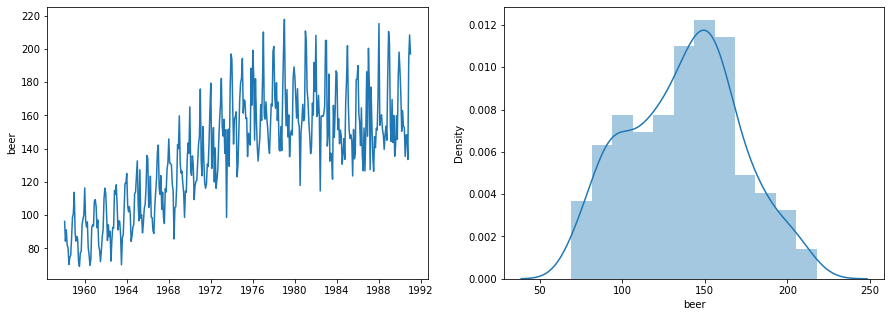

In [4]:
plot_ts_resid(CBE['beer'])

Notice that for each of these time series the amplitude of the seasonal variation grows with time. This is a common situation with real world data. Seeing this situation indicates that we should use a **multiplicative decomposition model**.  

The multiplicative model can be easily transformed to an additive model by taking the logarithm of the values.

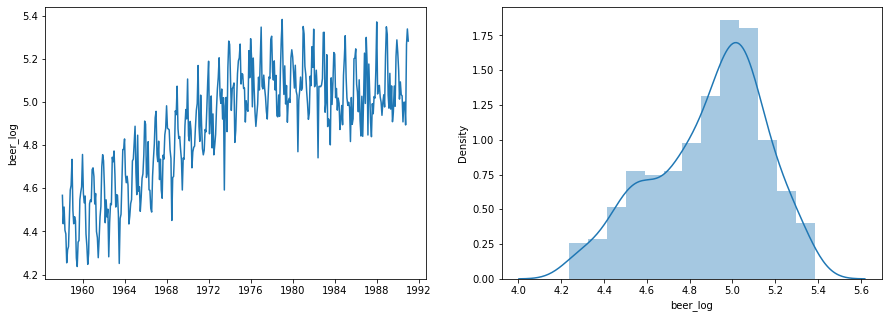

In [5]:
CBE['beer_log'] = np.log(CBE['beer'])
plot_ts_resid(CBE['beer_log'])

Notice the following properties about this time series.
- It has a significant trend.
- The time series have a noticeable seasonal component.
- The magnitude of the seasonal component increases with trend in the un-transformed time series. 
- The seasonal component of the log transformed series has a nearly constant magnitude, but decreases a bit with time. 

These results indicate that an STL decomposition is required. Further, a multiplicative (log transformed) STL model is preferred.


### Fitting linear regression

Before training any time series model, let's see how our old fried linear regression does. In cases where the data is relatively well behaved, we can train a model using linear regression, but we need to do some pre-processing to account for the time series nature of the data. This can be a manual and laborious process, but going through it can give us a sense of what trying to model time series "manually" looks like.

- Create a feature called `month_int`, which is equal to 1 when the month is January, 2 for February, and so on. Create another feature called `month_sqr` which is the square of `month_int`. <span style="color:red" float:right>[2 point]</span>
- One-hot-encode the `month_int` feature (creating one binary feature for each month), and normalize `month_int` and `month_sqr`. <span style="color:red" float:right>[2 point]</span>
- Create a feature called `beer_log_lag_1` which is the first lag of `beer_log` (as in the last known price of beer, when you look at the previous row). HINT: You can get lagged features using the `shift` method. <span style="color:red" float:right>[2 point]</span>

Scratch and Notes

- https://www.interviewqs.com/ddi-code-snippets/extract-month-year-pandas
- https://www.datasciencemadesimple.com/square-root-of-the-column-in-pandas-python-2/
- https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
- https://sparkbyexamples.com/pandas/normalize-columns-of-pandas-dataframe/#:~:text=To%20normalize%20all%20columns%20of,This%20example%20gives%20unbiased%20estimates.&text=Alternatively%2C%20you%20can%20also%20get,apply()%20and%20lambda%20.
- 

In [6]:
CBE.head()

,choc,beer,elec,beer_log
1958-01-31,1451,96.3,1497,4.567468
1958-02-28,2037,84.4,1463,4.435567
1958-03-31,2477,91.2,1648,4.513055
1958-04-30,2785,81.9,1595,4.405499
1958-05-31,2994,80.5,1777,4.388257


In [7]:
#Step 1 - Creating month_int
CBE.reset_index(inplace=True)
CBE['month_int'] = pd.DatetimeIndex(CBE['index']).month
CBE.head()

,index,choc,beer,elec,beer_log,month_int
0,1958-01-31,1451,96.3,1497,4.567468,1
1,1958-02-28,2037,84.4,1463,4.435567,2
2,1958-03-31,2477,91.2,1648,4.513055,3
3,1958-04-30,2785,81.9,1595,4.405499,4
4,1958-05-31,2994,80.5,1777,4.388257,5


In [8]:
#Step 2 - creating month_sqr
CBE['month_sqr']=CBE['month_int']**(2)
CBE.head()

,index,choc,beer,elec,beer_log,month_int,month_sqr
0,1958-01-31,1451,96.3,1497,4.567468,1,1
1,1958-02-28,2037,84.4,1463,4.435567,2,4
2,1958-03-31,2477,91.2,1648,4.513055,3,9
3,1958-04-30,2785,81.9,1595,4.405499,4,16
4,1958-05-31,2994,80.5,1777,4.388257,5,25


In [9]:
CBE.dtypes

index        datetime64[ns]
choc                  int64
beer                float64
elec                  int64
beer_log            float64
month_int             int64
month_sqr             int64
dtype: object

In [10]:
#Step 3 - OHE the month_int
CBE_dummy = pd.get_dummies(CBE['month_int'], prefix='month', dtype=int)
CBE_dummy['index']=pd.Series(CBE['index'])
CBE_dummy['beer']=pd.Series(CBE['beer'])
CBE_dummy['month_int']=pd.Series(CBE['month_int'])
CBE_dummy['month_sqr']=pd.Series(CBE['month_sqr'])
CBE_dummy['beer_log']=pd.Series(CBE['beer_log'])

CBE_dummy.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,index,beer,month_int,month_sqr,beer_log
0,1,0,0,0,0,0,0,0,0,0,0,0,1958-01-31,96.3,1,1,4.567468
1,0,1,0,0,0,0,0,0,0,0,0,0,1958-02-28,84.4,2,4,4.435567
2,0,0,1,0,0,0,0,0,0,0,0,0,1958-03-31,91.2,3,9,4.513055
3,0,0,0,1,0,0,0,0,0,0,0,0,1958-04-30,81.9,4,16,4.405499
4,0,0,0,0,1,0,0,0,0,0,0,0,1958-05-31,80.5,5,25,4.388257


In [11]:
#Step 4 - Normalize month_int and month_sqrt
#CBE_dummy['month_int_norm']=CBE_dummy['month_int'] / CBE_dummy['month_int'].max()
#CBE_dummy['month_sqr_norm']=CBE_dummy['month_sqr'] / CBE_dummy['month_sqr'].max()

CBE_dummy['month_int_norm'] = (CBE_dummy['month_int'] - CBE_dummy['month_int'].mean()) / (CBE_dummy['month_int'].std())
CBE_dummy['month_sqr_norm'] = (CBE_dummy['month_sqr'] - CBE_dummy['month_sqr'].mean()) / (CBE_dummy['month_sqr'].std())
CBE_dummy.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,index,beer,month_int,month_sqr,beer_log,month_int_norm,month_sqr_norm
0,1,0,0,0,0,0,0,0,0,0,0,0,1958-01-31,96.3,1,1,4.567468,-1.591242,-1.151852
1,0,1,0,0,0,0,0,0,0,0,0,0,1958-02-28,84.4,2,4,4.435567,-1.301925,-1.086857
2,0,0,1,0,0,0,0,0,0,0,0,0,1958-03-31,91.2,3,9,4.513055,-1.012609,-0.978533
3,0,0,0,1,0,0,0,0,0,0,0,0,1958-04-30,81.9,4,16,4.405499,-0.723292,-0.826878
4,0,0,0,0,1,0,0,0,0,0,0,0,1958-05-31,80.5,5,25,4.388257,-0.433975,-0.631894


In [12]:
#Step 5 - Create beer_log_lag_1
CBE_dummy['beer_log_lag_1']=CBE_dummy.beer_log.shift(1)
CBE_dummy.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,index,beer,month_int,month_sqr,beer_log,month_int_norm,month_sqr_norm,beer_log_lag_1
0,1,0,0,0,0,0,0,0,0,0,0,0,1958-01-31,96.3,1,1,4.567468,-1.591242,-1.151852,NaN
1,0,1,0,0,0,0,0,0,0,0,0,0,1958-02-28,84.4,2,4,4.435567,-1.301925,-1.086857,4.567468
2,0,0,1,0,0,0,0,0,0,0,0,0,1958-03-31,91.2,3,9,4.513055,-1.012609,-0.978533,4.435567
3,0,0,0,1,0,0,0,0,0,0,0,0,1958-04-30,81.9,4,16,4.405499,-0.723292,-0.826878,4.513055
4,0,0,0,0,1,0,0,0,0,0,0,0,1958-05-31,80.5,5,25,4.388257,-0.433975,-0.631894,4.405499


In [13]:
CBE_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   month_1         396 non-null    int32         
 1   month_2         396 non-null    int32         
 2   month_3         396 non-null    int32         
 3   month_4         396 non-null    int32         
 4   month_5         396 non-null    int32         
 5   month_6         396 non-null    int32         
 6   month_7         396 non-null    int32         
 7   month_8         396 non-null    int32         
 8   month_9         396 non-null    int32         
 9   month_10        396 non-null    int32         
 10  month_11        396 non-null    int32         
 11  month_12        396 non-null    int32         
 12  index           396 non-null    datetime64[ns]
 13  beer            396 non-null    float64       
 14  month_int       396 non-null    int64         
 15  month_

In [14]:
CBE_dummy.set_index('index', inplace=True)

With the feature engineering steps we took, we should be able to train a linear regression model now. With `month_int` and `month_sqr` the model should be able to find a trend over the course of the year, which is either linear or curvelinear with a single peak or trough. By one-hot-encoding `month_int` the model can also capture month to month effects. Finally, using a lagged feature, the model can anchor its beer price prediction on the last known price.

- Split the data into training and test sets, using the last 12 months of data for testing. <span style="color:red" float:right>[2 point]</span> 
- Train a linear regression model to predict beer price using onely the features we created earlier. <span style="color:red" float:right>[2 point]</span> 

In [15]:
#Step 1 - split into training and test sets using last 12 months

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
CBE_dummy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 1958-01-31 to 1990-12-31
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   month_1         396 non-null    int32  
 1   month_2         396 non-null    int32  
 2   month_3         396 non-null    int32  
 3   month_4         396 non-null    int32  
 4   month_5         396 non-null    int32  
 5   month_6         396 non-null    int32  
 6   month_7         396 non-null    int32  
 7   month_8         396 non-null    int32  
 8   month_9         396 non-null    int32  
 9   month_10        396 non-null    int32  
 10  month_11        396 non-null    int32  
 11  month_12        396 non-null    int32  
 12  beer            396 non-null    float64
 13  month_int       396 non-null    int64  
 14  month_sqr       396 non-null    int64  
 15  beer_log        396 non-null    float64
 16  month_int_norm  396 non-null    float64
 17  month_sqr_norm  

In [16]:
x = CBE_dummy.drop(columns=['beer', 'beer_log'])
y = CBE_dummy['beer']
x_train=x[:-12]#dropping 12 bottom rows
x_test=CBE_dummy[-12:]
y_train=y[:-12]
y_test=y[-12:]

In [17]:
x_train_ols = CBE_dummy[:-12]
x_test_ols = CBE_dummy[-12:]

In [22]:
#train, test = train_test_split(CBE_dummy, train_size=384, test_size=12, random_state=40, shuffle=False)

In [23]:
#Fact checking to make sure it worked correctly
#test

In [24]:
x_train.columns

Index(['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'month_int', 'month_sqr', 'month_int_norm', 'month_sqr_norm',
       'beer_log_lag_1'],
      dtype='object')

In [25]:
#Step 2 - train a linear regression model to predict beer price using only the OHE, month_int_norm, month_sqr_norm, beer_log_lag_1
model_beer = sm.ols(formula = 'beer_log ~ beer_log_lag_1 + month_int_norm + month_sqr_norm + month_1 + month_2 + month_3 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10 + month_11 + month_12',
                    data = x_train_ols).fit()
print(model_beer.summary2())
train_pred = model_beer.predict(x_train_ols)
test_pred = model_beer.predict(x_test_ols)


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.861    
Dependent Variable: beer_log         AIC:                -689.1533
Date:               2022-04-27 10:23 BIC:                -637.8288
No. Observations:   383              Log-Likelihood:     357.58   
Df Model:           12               F-statistic:        197.9    
Df Residuals:       370              Prob (F-statistic): 9.49e-153
R-squared:          0.865            Scale:              0.0093668
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept           0.4159   0.0967  4.3002 0.0000  0.2257  0.6061
beer_log_lag_1      0.9080   0.0214 42.3886 0.0000  0.8659  0.9502
month_int_norm      0.0422   0.0062  6.7797 0.0000  0.0300  0.0545
month_sqr_norm      0.0216   0.0062  3.4936 0.0005  0.0095  0.0338
month_1      

- As expected, the beer_log_lag_1 has an incredibly high coefficient - signifying that it is strongly correlated, a little confused on whether or not to use a lag from the dependent variable - thoughts on this?

- Plot a line plot of the original time series, and to the same plot add line plots to show the predictions on the training data and the test data. Use separate colors for each. <span style="color:red" float:right>[3 point]</span> 

Scratch and Notes

- https://www.machinelearningplus.com/time-series/time-series-analysis-python/
- https://stackoverflow.com/questions/52308749/how-do-i-create-a-multiline-plot-using-seaborn
- https://pythonguides.com/python-plot-multiple-lines/
- https://pandas.pydata.org/docs/reference/api/pandas.Series.html

#If you add the predicted values into the dataframe, can use this code here, if not use the below

CBE_dummy.head()
CBE_dummy.set_index('index', inplace=True)
beer_ser = pd.Series(data=CBE_dummy['beer_log'])
pred_ser = pd.Series(data=CBE_dummy['beer_pred'])
test_ser = pd.Series(data=CBE_dummy['beer_test_pred'])
pred_ser

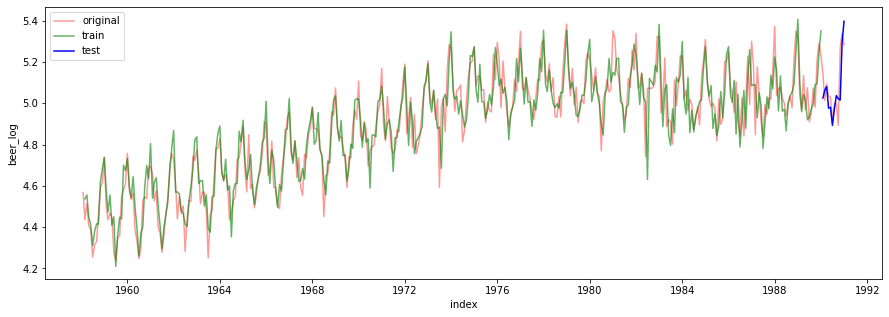

In [26]:
sns.lineplot(x = CBE_dummy.index, y = CBE_dummy['beer_log'], color = 'r', alpha = 0.4)#, marker='o');
sns.lineplot(x = x_train_ols.index, y = train_pred, color = 'g', alpha = 0.6), #marker='<');
sns.lineplot(x = x_test_ols.index, y = test_pred, color = 'b', markers=True);
plt.legend(['original', 'train', 'test']);

- Compute the **root mean square error (RMSE)** of the model on the test data and plot the line plot and the histogram of the residual (beer price minus forecast) using the `plot_ts_resid` helper function. What conclusion would you draw about the model we fit? <span style="color:red" float:right>[2 point]</span> 

Scratch and Notes
- https://www.delftstack.com/howto/python-pandas/pandas-subtract-two-columns/
- https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/

CBE_dummy['RMSE'] = CBE_dummy['beer']-CBE_dummy['beer_pred']
CBE_dummy.head()

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(x_test_ols['beer_log'], test_pred))
rmse

0.1000341707084085

In [28]:
resid = x_train_ols['beer_log']-train_pred

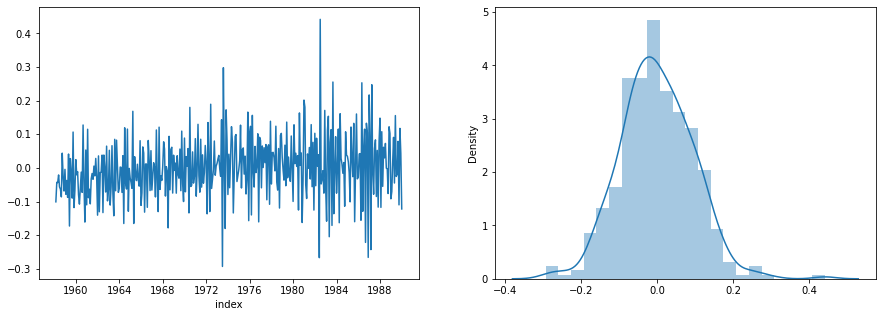

In [29]:
plot_ts_resid(resid)

### Fitting a time series model

Let's now try the models we learned about in this lesson. By doing so, we can later compare the two approaches and appreciate the pros and cons.

- Use the `decomp_ts` helper function to decompose `beer_log`. Remove the NAs from the data, then use the `plot` method to plot a line plot of the components. <span style="color:red" float:right>[3 point]</span> 

Scratch and Notes
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.bfill.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ffill.html

In [30]:
def decomp_ts(ts, period, model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model, period = period)
    return(pd.DataFrame({'ts': ts, 'trend': res.trend, 'seasonal': res.seasonal, 'resid': res.resid}, 
                        index = ts.index))

In [31]:
decomp_12=decomp_ts(CBE_dummy['beer_log'], period=12)

In [32]:
decomp_12.head()

,ts,trend,seasonal,resid
index,,,,
1958-01-31,4.567468,NaN,0.039683,NaN
1958-02-28,4.435567,NaN,-0.025683,NaN
1958-03-31,4.513055,NaN,0.054447,NaN
1958-04-30,4.405499,NaN,-0.048373,NaN
1958-05-31,4.388257,NaN,-0.085620,NaN


In [33]:
decomp_12.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 1958-01-31 to 1990-12-31
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ts        396 non-null    float64
 1   trend     384 non-null    float64
 2   seasonal  396 non-null    float64
 3   resid     384 non-null    float64
dtypes: float64(4)
memory usage: 15.5 KB


In [34]:
decomp_12 = decomp_12.bfill().ffill()

decomp_12.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 1958-01-31 to 1990-12-31
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ts        396 non-null    float64
 1   trend     396 non-null    float64
 2   seasonal  396 non-null    float64
 3   resid     396 non-null    float64
dtypes: float64(4)
memory usage: 15.5 KB


<Figure size 1080x360 with 0 Axes>

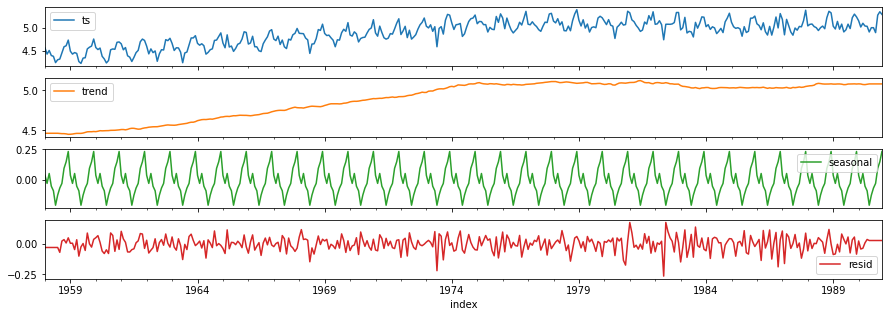

In [35]:
plt.figure()
decomp_12.plot(subplots=True);

- Compute and plot the ACF and PACF for the remainder (residual) series, up to 36 lags. <span style="color:red" float:right>[2 point]</span>

Scratch and Notes
- https://www.delftstack.com/howto/python-pandas/pandas-dataframe-to-series/#:~:text=To%20convert%20the%20last%20or,from%20Pandas%20dataframe%20to%20series.
- Lags correspond to time throughout the year as well

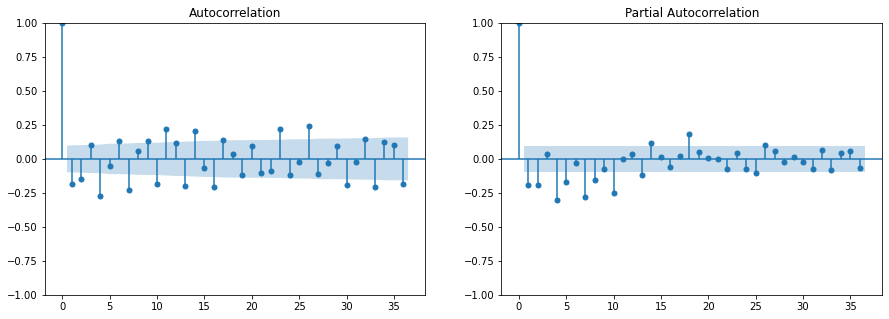

In [36]:
#ACF - Autocorrelation - From exercise above
plot_acf_pacf(decomp_12['resid'], lags = 36)

- We would like the partial autocorrleation to continue to decrease? Is that the point of this graph?

As you can imagine, with real data things can look very messy. The ACF and PACF can exhibit both AR and MA behavior and it's hard to know what degrees to choose. So we will use the `auto_arima` function to help us: It  iterates over a grid of $(p, d, q)$ and seasonal $(P, D, Q)$ values. For each combination the BIC is computed and compared to the best previous model. For each combination the BIC is computed and compared to the best previous model. The better model is the one with the lowest BIC: The **Bayesian information criteria (BIC)** is a measure for assessing a model's fit:

$$
\begin{align}
\text{BIC} &= \ln(n)k - 2 \ln(\hat L)
\end{align}
$$

where $\hat L$ is the likelihood of the data given the fitted model parmaters, $k$ is the number of model parameters, and $n$ is the number of observations. Lower values for BIC means we have a better fit.

The code below implements `auto_arima`. As you can see, we provide it with the data, some maximum value for the hyper-pramaters $(p, d, q)$ and $(P, D, Q)$. It's very unusual to choose a number greater than 3. Run the next cell and examine the results. The function returns the best model, i.e. the model whose hyper-parameters gave the lowest BIC.

In [37]:
!pip install pmdarima

In [38]:
validation_cut_off = '1989-12-31'

In [39]:
from pmdarima import auto_arima
best_fit = auto_arima(CBE_dummy.loc[:validation_cut_off, 'beer_log'], 
                      max_p = 3, max_d = 1, max_q = 3, 
                      m = 12, max_P = 1, max_D = 1, max_Q = 1, 
                      information_criterion = 'bic', 
                      trace = True, error_action = 'ignore', suppress_warnings = True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : BIC=inf, Time=2.67 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=-425.265, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=-623.432, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=-597.582, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=-431.152, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=-443.850, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=inf, Time=1.46 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=-548.074, Time=0.44 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : BIC=-543.236, Time=0.23 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : BIC=-691.971, Time=0.89 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : BIC=-444.279, Time=0.07 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : BIC=-819.187, Time=1.73 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : BIC=-560.629, Time=0.50 sec
 ARIMA(3,1,0)(1,0,1)[12] intercept   : BIC=-817.090, Time=2.02 sec
 ARIMA(2,1,1)(1,0,1)[12] inte

Let's take a look at the best model's summary:

In [40]:
print(best_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  384
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 461.679
Date:                            Wed, 27 Apr 2022   AIC                           -911.358
Time:                                    10:24:14   BIC                           -887.669
Sample:                                         0   HQIC                          -901.961
                                            - 384                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2349      0.049     -4.769      0.000      -0.331      -0.138
ar.L2         -0.1860      0.053   

In [41]:
type(best_fit)


pmdarima.arima.arima.ARIMA

Let's now visualize the forecast. With time series models we use the `predict_in_sample` to make predictions for the range of data that we used during training, and we use `predict` to make forecasts.

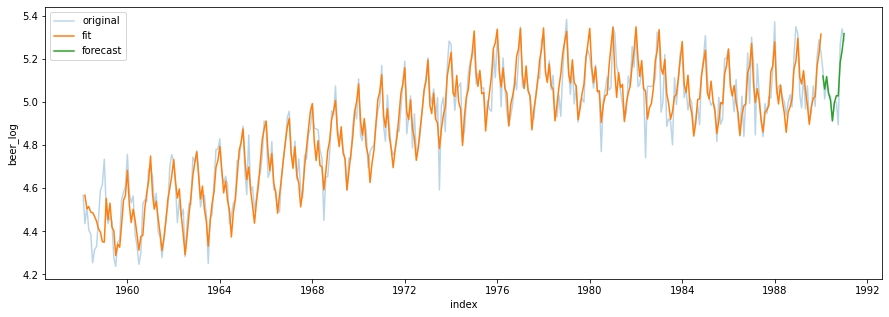

In [43]:
start_idx = 1
train_idx = x_train.reset_index().index[start_idx:]
n_periods = len(x_test)

sns.lineplot(CBE_dummy.index, CBE_dummy['beer_log'], alpha = 0.3)
sns.lineplot(x_train.index[train_idx], best_fit.predict_in_sample(start = start_idx, end = train_idx.max()))
sns.lineplot(x_test.index, best_fit.predict(n_periods = n_periods))
plt.legend(['original', 'fit', 'forecast']);

- Getting Hung up here - struggling to answer this last part, sorry Sean

In [44]:
forecast = pd.DataFrame(best_fit.predict_in_sample(start=start_idx, end=train_idx.max()), index=CBE_dummy.index, columns=['Prediction'])

ValueError: Shape of passed values is (383, 1), indices imply (396, 1)

In [45]:
predictions = np.concatenate((best_fit.predict_in_sample(start = start_idx, end = train_idx.max()),best_fit.predict(n_periods = 12)), axis=0)

In [46]:
CBE_dummy['pred_arima'] = predictions

ValueError: Length of values (395) does not match length of index (396)

Notice how the predictions are initially a bit off, but overall the forecasts look reasonable.

- Compute the RMSE and use `plot_ts_resid` to plot the line plot and the histogram of the residuals. How does the RMSE for this model compare the the linear regression model? <span style="color:red" float:right>[2 point]</span>

Scratch and Notes

- https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd
- https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [47]:
#From above
def plot_ts_resid(x):
    x = x[x.notna()] # remove NAs
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    fig = sns.lineplot(x.index, x, ax = axes[0])
    fig = sns.distplot(x, ax = axes[1]);
    return None

In [48]:
decomp_12.head()

,ts,trend,seasonal,resid
index,,,,
1958-01-31,4.567468,4.464318,0.039683,-0.02868
1958-02-28,4.435567,4.464318,-0.025683,-0.02868
1958-03-31,4.513055,4.464318,0.054447,-0.02868
1958-04-30,4.405499,4.464318,-0.048373,-0.02868
1958-05-31,4.388257,4.464318,-0.085620,-0.02868


We hope the assignment convinced you that the decision as to which model is better is not always clear. Of course we can rely on a metric like RMSE, but we don't want that to be the sole determinant. The level of familiarity with this or that algorithm should also be important. For example, we spent a lot of time learning about linear models, so even if the linear model is a slight worse fit we may prefer it because they are efficient and we can focus on feature engineering to improve its performance. ARIMA models on the other hand have the advantage of taking care of a lot of the feature engineering, but they are more difficult to explainr and require more experience in order to tune well. These sorts of trade-offs are very common in data science.

# End of assignment